In [1]:
#!/usr/bin/env python

from __future__ import print_function

try:
    import matplotlib
    matplotlib.use('Agg')
except ImportError:
    pass

import argparse, json

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
from chainer import Variable
import numpy as np

In [2]:
class CorrNet(chainer.Chain):
    
    def __init__(self, n_units, x_size, y_size, c=0.2, activate=F.identity):
        super(CorrNet, self).__init__(
            encX = L.Linear(x_size, n_units, nobias=True),  
            encY = L.Linear(y_size, n_units, nobias=True),
            enc_b = L.Bias(shape=(n_units,)),
            decX = L.Linear(n_units, x_size),
            decY = L.Linear(n_units, y_size),
        )
        
        self.x_size = x_size
        self.y_size = y_size
        self.c = c
        self.activate = activate

        
    def __call__(self, x, y, test=False):
        h1 = self.activate(self.enc_b(self.encX(x)))
        recX1 = self.decX(h1)
        recY1 = self.decY(h1)
        loss1 = F.mean_squared_error(x, recX1) + F.mean_squared_error(y, recY1)
        
        h2 = self.activate(self.enc_b(self.encY(y)))
        recX2 = self.decX(h2)
        recY2 = self.decY(h2)
        loss2 = F.mean_squared_error(x, recX2) + F.mean_squared_error(y, recY2)
        
        h3 = self.activate(self.enc_b(self.encX(x) + self.encY(y)))
        recX3 = self.decX(h3)
        recY3 = self.decY(h3)
        loss3 = F.mean_squared_error(x, recX3) + F.mean_squared_error(y, recY3)
             
        batch_size, ndim = h1.data.shape

        h1_mean = F.sum(h1, axis=1) / ndim
        h1_mean = F.expand_dims(h1_mean, axis=1)
        h1_mean = F.broadcast_to(h1_mean, h1.data.shape)
        h1_centered = h1 - h1_mean

        h2_mean = F.sum(h2, axis=1) / ndim
        h2_mean = F.expand_dims(h2_mean, axis=1)
        h2_mean = F.broadcast_to(h2_mean, h2.data.shape)
        h2_centered = h2 - h2_mean

        numerator = F.sum(h1_centered*h2_centered, axis=1)
        denominator = F.sqrt(F.sum(h1_centered*h1_centered, axis=1) * F.sum(h2_centered*h2_centered, axis=1))
        corr = numerator / denominator

        loss4 = F.sum(corr) / batch_size
        
        if test == True:
            return self.recX3, self.recY3
        
        self.loss = loss1 + loss2 + loss3 - self.c * loss4
        chainer.reporter.report({'loss': self.loss,
                                'loss1': loss1,
                                'loss2': loss2,
                                'loss3': loss3,
                                'corr': loss4,
                                }, self)
        return self.loss
    
    def encX_dec(self, x):
        x = xp.array(x, xp.float32)
        h = self.activate(self.enc_b(self.encX(x)))
        return chainer.cuda.to_cpu(self.decX(h).data), chainer.cuda.to_cpu(self.decY(h).data)
    
    
    def encY_dec(self, y):
        y = xp.array(y, xp.float32)
        h = self.activate(self.enc_b(self.encY(y)))
        return chainer.cuda.to_cpu(self.decX(h).data), chainer.cuda.to_cpu(self.decY(h).data)
    
    
    def encXY_dec(self, x, y):
        x, y = xp.array(x, xp.float32), xp.array(y, xp.float32)
        h = self.activate(self.enc_b(self.encX(x) + self.encY(y)))
        return chainer.cuda.to_cpu(self.decX(h).data), chainer.cuda.to_cpu(self.decY(h).data)

In [3]:
# def main():
#     parser = argparse.ArgumentParser(description='Chainer example: MNIST')
#     parser.add_argument('--batchsize', '-b', type=int, default=100,
#                         help='Number of images in each mini-batch')
#     parser.add_argument('--epoch', '-e', type=int, default=20,
#                         help='Number of sweeps over the dataset to train')
#     parser.add_argument('--frequency', '-f', type=int, default=-1,
#                         help='Frequency of taking a snapshot')
#     parser.add_argument('--gpu', '-g', type=int, default=-1,
#                         help='GPU ID (negative value indicates CPU)')
#     parser.add_argument('--out', '-o', default='result',
#                         help='Directory to output the result')
#     parser.add_argument('--resume', '-r', default='',
#                         help='Resume the training from snapshot')
#     parser.add_argument('--unit', '-u', type=int, default=1000,
#                         help='Number of units')
#     args = parser.parse_args()
import easydict
args = easydict.EasyDict({
        "batchsize": 100,
        "epoch": 20,
        "gpu": -1,
        "out": "mnist_output",
        "resume": False,
        "unit": 20,
        "c": 0.1,
        "frequency": 100,
        "activation": "sigmoid", 
})


print('GPU: {}'.format(args.gpu))
print('# unit: {}'.format(args.unit))
print('# Minibatch-size: {}'.format(args.batchsize))
print('# epoch: {}'.format(args.epoch))
print('')

from chainer import cuda
xp = cuda.cupy if args.gpu >= 0 else np

GPU: -1
# unit: 20
# Minibatch-size: 100
# epoch: 20



In [4]:
from chainer.datasets import tuple_dataset

def y_label2one_hot(tupled_data):
    x_list, y_list = [], []

    for i in range(len(tupled_data)):
        one_train = list(tupled_data[i])
        label = one_train[1]

        one_hot = np.zeros(10)
        one_hot[label] =1

        x_list.append(one_train[0])
        y_list.append(one_hot.astype(np.float32))
        
    return tuple_dataset.TupleDataset(x_list, y_list)

# Load the MNIST dataset
train, test = chainer.datasets.get_mnist()

train = y_label2one_hot(train)
test = y_label2one_hot(test)

train_iter = chainer.iterators.SerialIterator(train, args.batchsize)
test_iter = chainer.iterators.SerialIterator(test, args.batchsize,
                                             repeat=False, shuffle=False)


x_size = train[0][0].shape[0]
y_size = train[0][1].shape[0]
# Set up a neural network to train
# Classifier reports softmax cross entropy loss and accuracy at every
# iteration, which will be used by the PrintReport extension below.
#     model = L.Classifier(MLP(args.unit, 10))
model = CorrNet(args.unit, x_size, y_size, c=args.c, activate=eval("F." + args.activation))

if args.gpu >= 0:
    chainer.cuda.get_device(args.gpu).use()  # Make a specified GPU current
    model.to_gpu()  # Copy the model to the GPU

# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

# Set up a trainer
updater = training.StandardUpdater(train_iter, optimizer, device=args.gpu)
trainer = training.Trainer(updater, (args.epoch, 'epoch'), out=args.out)

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=args.gpu))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
#     if extensions.PlotReport.available():
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

trainer.extend(
    extensions.PlotReport(['main/loss1', 'main/loss2', 'main/loss3',  'main/corr'],
                          'epoch', file_name='detail_loss.png'))


# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/corr', 'validation/main/corr', 'elapsed_time']))

# # Print a progress bar to stdout
# trainer.extend(extensions.ProgressBar())

if args.resume:
    # Resume from a snapshot
    chainer.serializers.load_npz(args.resume, trainer)
    

# Run the training
trainer.run()

epoch       main/loss   validation/main/loss  main/corr   validation/main/corr  elapsed_time
1           0.357312    0.194076              0.711138    0.854739              9.22959       
2           0.153086    0.126354              0.860733    0.873066              18.7985       
3           0.117792    0.109526              0.883174    0.896231              28.3096       
4           0.106654    0.101708              0.904538    0.913977              37.8821       
5           0.100103    0.0964354             0.918304    0.922988              48.0566       
6           0.094195    0.0899471             0.925333    0.927998              58.3081       
7           0.0887226   0.0849984             0.929194    0.931897              68.2392       
8           0.0840477   0.0809552             0.932687    0.935073              80.0663       
9           0.0803637   0.077584              0.936075    0.938904              89.6289       
10          0.0774161   0.0749414             0.9394

In [5]:
# write parameter values to json file
with open(args.out + "/args.json", "w") as f:
    json.dump(args, f, ensure_ascii=False, indent=4)

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

#### もとの画像のチェック

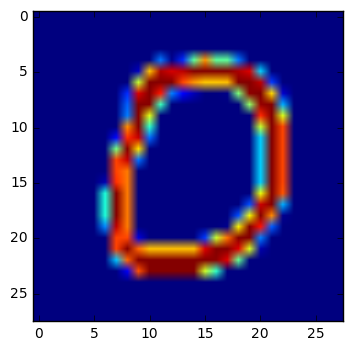

In [7]:
test_id = 10

## original
img = test[test_id][0].reshape([28,28])

plt.imshow(img)

#### 画像とラベル情報両方使って復元

(<matplotlib.image.AxesImage at 0x11ed01e90>,
 array([[  1.00761187e+00,   4.30354476e-02,  -5.03387488e-02,
           1.14981383e-02,   5.31181693e-04,   2.23932154e-02,
          -4.30855602e-02,   8.64514709e-03,   2.18936708e-02,
          -1.96339935e-02]], dtype=float32))

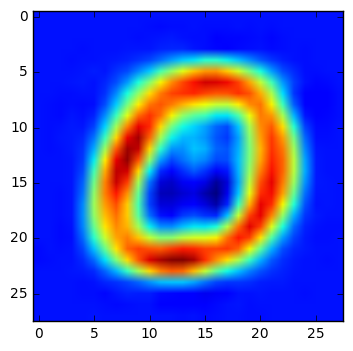

In [8]:
recX, recY = model.encXY_dec(test[test_id][0][xp.newaxis,: ], test[test_id][1][xp.newaxis,: ])

plt.imshow(recX.reshape([28,28])), recY

#### 画像情報のみから復元

(<matplotlib.image.AxesImage at 0x11fba3750>,
 array([[ 0.86736488,  0.02842727,  0.08068168,  0.03469785, -0.04725035,
          0.10045974, -0.06853412,  0.0031164 ,  0.01942707,  0.00741422]], dtype=float32))

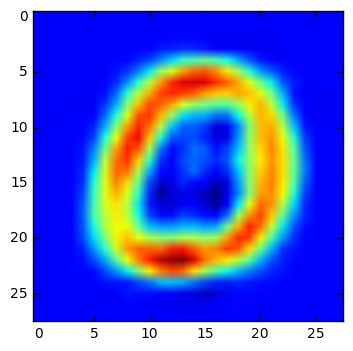

In [9]:
recX, recY = model.encX_dec(test[test_id][0][xp.newaxis,: ])

plt.imshow(recX.reshape([28,28])), recY

#### ラベル情報のみから復元

(<matplotlib.image.AxesImage at 0x11e47f190>,
 array([[  9.62331116e-01,   1.44079328e-02,   1.48070119e-02,
          -1.10717565e-02,  -1.17395669e-02,   6.86000660e-03,
           1.03117526e-03,   6.66609406e-03,   7.69183040e-04,
           7.17282295e-04]], dtype=float32))

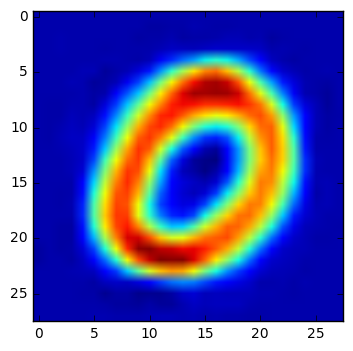

In [10]:
recX, recY = model.encY_dec(test[test_id][1][xp.newaxis,: ])

plt.imshow(recX.reshape([28,28])), recY

#### ラベル情報のみから復元 (0と8を混ぜ合わせたもの)

(<matplotlib.image.AxesImage at 0x11e6a3790>,
 array([[ 0.81600225, -0.07510847,  0.05551633, -0.01802452,  0.01108487,
         -0.14947464, -0.13043545, -0.01694682,  0.52228445, -0.03257205]], dtype=float32))

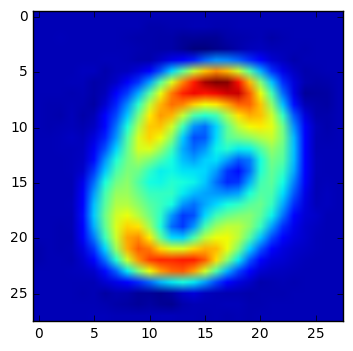

In [11]:
recX, recY = model.encY_dec(xp.array([[1,0,0,0,0,0,0,0,1,0]], dtype=xp.float32))

plt.imshow(recX.reshape([28,28])), recY